In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

In [4]:
# Merge datasets for comprehensive analysis
merged_data = pd.merge(transactions, customers, on="CustomerID", how="inner")
merged_data = pd.merge(merged_data, products, on="ProductID", how="inner")
merged_data.rename(columns={'Price_x': 'Price_product', 'Price_y': 'Price_Transaction'}, inplace=True)

In [7]:
# Feature engineering: Aggregate transaction data by customer
customer_features = merged_data.groupby("CustomerID").agg({
    "Quantity": "sum",
    "TotalValue": "sum",
    "Price_Transaction": "mean",
    "Category": lambda x: x.mode()[0] if not x.mode().empty else "Unknown",
    "Region": lambda x: x.mode()[0] if not x.mode().empty else "Unknown"
}).reset_index()

# Encode categorical data (Category and Region)
customer_features = pd.get_dummies(customer_features, columns=["Category", "Region"], drop_first=True)

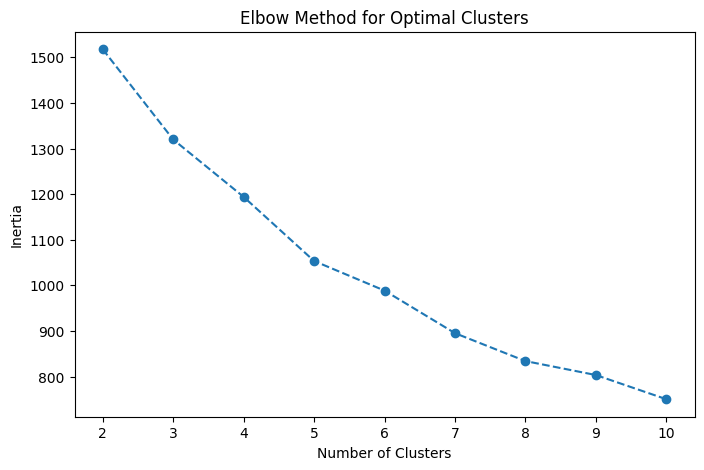

In [8]:
# Scale numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop(columns=["CustomerID"]))

# Determine the optimal number of clusters using the Elbow Method
inertia = []
range_clusters = range(2, 11)
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [27]:
# Perform clustering with the optimal number of clusters (chosen visually from the Elbow Method)
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to the original data
customer_features["Cluster"] = labels

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, labels)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 1.5609169348735699


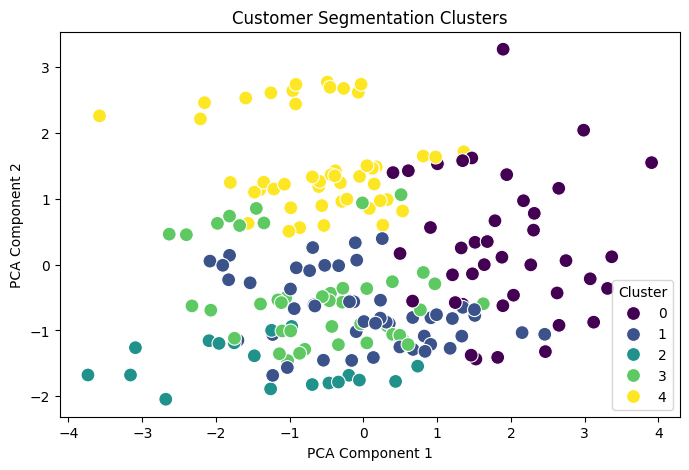

In [28]:
# Visualize the clusters (using the first two PCA components for simplicity)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=labels, palette="viridis", s=100)
plt.title("Customer Segmentation Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [23]:
# Save clustering results to CSV
customer_features.to_csv("Customer_Clusters.csv", index=False)



In [24]:
# Display clustering results
print("Clustering results:")
customer_features.head()

Clustering results:


,CustomerID,Quantity,TotalValue,Price_Transaction,Category_Clothing,Category_Electronics,Category_Home Decor,Region_Europe,Region_North America,Region_South America,Cluster
0,C0001,12,3354.52,278.334000,False,True,False,False,False,True,1
1,C0002,10,1862.74,208.920000,True,False,False,False,False,False,4
2,C0003,14,2725.38,195.707500,False,False,True,False,False,True,2
3,C0004,23,5354.88,240.636250,False,False,False,False,False,True,0
4,C0005,7,2034.24,291.603333,False,True,False,False,False,False,1
